In [2]:
# Load environment variables and set up auto-reload
from dotenv import load_dotenv
load_dotenv()

%load_ext autoreload
"""
load_ext is a magic function in IPython/Jupyter NB that allows you to load and 
reload Python modules automatically.
"""
%autoreload 2
"""
This tells the extension how to reload modules:

0 → Disable autoreload.

1 → Reload only modules you explicitly import with %aimport.

2 → Reload all modules automatically every time you run a cell (except those excluded with %aimport).
"""

'\nThis tells the extension how to reload modules:\n\n0 → Disable autoreload.\n\n1 → Reload only modules you explicitly import with %aimport.\n\n2 → Reload all modules automatically every time you run a cell (except those excluded with %aimport).\n'

In [3]:
from rich.console import Console
from rich.panel import Panel
from rich.text import Text
import json
console = Console()

In [4]:
def show_prompt(prompt_text: str, title: str = "Prompt", border_style: str = "blue"):
    """
    Display a prompt with rich formatting and XML tag highlighting.
    
    Args:
        prompt_text: The prompt string to display
        title: Title for the panel (default: "Prompt")
        border_style: Border color style (default: "blue")
    """
    # Create a formatted display of the prompt
    formatted_text = Text(prompt_text)
    formatted_text.highlight_regex(r'<[^>]+>', style="bold blue")  # Highlight XML tags
    formatted_text.highlight_regex(r'##[^#\n]+', style="bold magenta")  # Highlight headers
    formatted_text.highlight_regex(r'###[^#\n]+', style="bold cyan")  # Highlight sub-headers

    # Display in a panel for better presentation
    console.print(Panel(
        formatted_text, 
        title=f"[bold green]{title}[/bold green]",
        border_style=border_style,
        padding=(1, 2)
    ))

In [5]:
from prompts import clarify_with_user_instructions
show_prompt(clarify_with_user_instructions, "Clarify with User Instructions", "red")
"""
tags in prompts (<Messages> ... </Messages>) are a common prompt-engineering trick.
By adding clear delimiters (<Messages> ... </Messages>), you're telling the LLM:
“Everything inside here is conversation history; don't confuse it with instructions.”
Wrapping sections in tags (like XML/HTML style) makes it easier for the LLM to 
understand structure.

If you later want the LLM to produce structured output (e.g., JSON, Pydantic 
models), it's consistent to feed it structured input too.
"""

╭──────────────────────────────────────── Clarify with User Instructions ─────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│  These are the messages that have been exchanged so far from the user asking for the report:                    │
│  <Messages>                                                                                                     │
│  {messages}                                                                                                     │
│  </Messages>                                                                                                    │
│                                                                                                                 │
│  Today's date is {date}.                                                                                        │
│                                                                                                                 │
│  Assess whether you need to ask a clarifying question, or if the user has already provided enough information   │
│  for you to start research.                                                                                     │
│  IMPORTANT: If you can see in the messages history that you have already asked a clarifying question, you       │
│  almost always do not need to ask another one. Only ask another question if ABSOLUTELY NECESSARY.               │
│                                                                                                                 │
│  If there are acronyms, abbreviations, or unknown terms, ask the user to clarify.                               │
│  If you need to ask a question, follow these guidelines:                                                        │
│  - Be concise while gathering all necessary information                                                         │
│  - Make sure to gather all the information needed to carry out the research task in a concise, well-structured  │
│  manner.                                                                                                        │
│  - Use bullet points or numbered lists if appropriate for clarity. Make sure that this uses markdown            │
│  formatting and will be rendered correctly if the string output is passed to a markdown renderer.               │
│  - Don't ask for unnecessary information, or information that the user has already provided. If you can see     │
│  that the user has already provided the information, do not ask for it again.                                   │
│                                                                                                                 │
│  Respond in valid JSON format with these exact keys:                                                            │
│  "need_clarification": boolean,                                                                                 │
│  "question": "<question to ask the user to clarify the report scope>",                                          │
│  "verification": "<verification message that we will start research>"                                           │
│                                                                                                                 │
│  If you need to ask a clarifying question, return:                                                              │
│  "need_clarification": true,                                                                                    │
│  "question": "<your clarifying question>",                                                                      │
│  "verification": ""                                                                                             │
│                                                       

"\ntags in prompts (<Messages> ... </Messages>) are a common prompt-engineering trick.\nBy adding clear delimiters (<Messages> ... </Messages>), you're telling the LLM:\n“Everything inside here is conversation history; don't confuse it with instructions.”\nWrapping sections in tags (like XML/HTML style) makes it easier for the LLM to \nunderstand structure.\n\nIf you later want the LLM to produce structured output (e.g., JSON, Pydantic \nmodels), it's consistent to feed it structured input too.\n"

In [ ]:
"""State Definitions and Pydantic Schemas for Research Scoping.

This defines the state objects and structured schemas used for
the research agent scoping workflow, including researcher state management and output schemas.
"""

import operator
"""
The operator module exports a set of efficient functions that correspond to 
Python's built-in operators (+, -, *, getitem, attrgetter, etc.).
ex-
import operator
nums = [5, 2, 9]
sorted_nums = sorted(nums, key=operator.neg)  # sort by negative value
Output = [9, 5, 2]
"""

from typing_extensions import Optional, Annotated, List, Sequence
"""
The typing module in Python provides type hints—a way to describe the expected 
types of variables, function parameters, and return values.
ex-
from typing import List

def add_numbers(nums: List[int]) -> int:
    return sum(nums)

without typing, the same function would have been
def add(a, b):
    return a + b
Similarly, typing_extensions backports newer typing features for Python 
versions that don’t yet support them in the built-in typing module.
"""
from langchain_core.messages import BaseMessage
"""
BaseMessage is the base class for different kinds of messages 
(user messages, AI messages, system messages, etc.) in a conversational context.
"""

from langgraph.graph import MessagesState
"""
MessagesState is a specialized state container for holding message 
history in the graph execution.
"""
from langgraph.graph.message import add_messages
"""
add_messages lets you append new messages to an existing conversation state.
ex-
from langgraph.graph.message import add_messages
state = MessagesState(messages=[])
new_state = add_messages(state, [HumanMessage(content="Hello again!")])
"""
from pydantic import BaseModel, Field
"""
BaseModel → base class for defining structured data models with validation.

Field → lets you customize field properties (default values, metadata, validators).

ex-
name: str = Field(..., description="User's full name")
age: int = Field(ge=0, description="Age must be non-negative")
So Field defines the datatype.
"""
# ===== STATE DEFINITIONS =====

class AgentInputState(MessagesState):
    """MessageState only contains "messages" which is appended everytime an
    agent updates it.
    Input state for the full agent - only contains "messages" from user input.
    So, the graph will be invoked with this state or like this:
    deep_researcher_builder = StateGraph(AgentState, input_schema=AgentInputState)
    .
    .
    .
    result = scope.invoke({"messages": [HumanMessage(content="I wa...
    """
    pass

class AgentState(MessagesState):
    """
    Main state for the full multi-agent research system.
    
    Extends MessagesState with additional fields for research coordination.
    Note: Some fields are duplicated across different state classes for proper
    state management between subgraphs and the main workflow.
    """

    # Research brief generated from user conversation history
    research_brief: Optional[str]
    # Messages exchanged with the supervisor agent for coordination
    supervisor_messages: Annotated[Sequence[BaseMessage], add_messages]
    # Raw unprocessed research notes collected during the research phase
    raw_notes: Annotated[list[str], operator.add] = []
    # Processed and structured notes ready for report generation
    notes: Annotated[list[str], operator.add] = []
    # Final formatted research report
    final_report: str

# ===== STRUCTURED OUTPUT SCHEMAS =====

class ClarifyWithUser(BaseModel):
    """Schema for user clarification decision and questions."""
    
    need_clarification: bool = Field(
        description="Whether the user needs to be asked a clarifying question.",
    )
    question: str = Field(
        description="A question to ask the user to clarify the report scope",
    )
    verification: str = Field(
        description="Verify message that we will start research after the user has provided the necessary information.",
    )

class ResearchQuestion(BaseModel):
    """Schema for structured research brief generation."""
    
    research_brief: str = Field(
        description="A research question that will be used to guide the research.",
    )

In [ ]:
"""User Clarification and Research Brief Generation.

This module implements the scoping phase of the research workflow, where we:
1. Assess if the user's request needs clarification
2. Generate a detailed research brief from the conversation

The workflow uses structured output to make deterministic decisions about
whether sufficient context exists to proceed with research.
"""

from datetime import datetime
from typing_extensions import Literal

from langchain.chat_models import init_chat_model
from langchain_core.messages import HumanMessage, AIMessage, get_buffer_string
from langgraph.graph import StateGraph, START, END
from langgraph.types import Command

from prompts import clarify_with_user_instructions, transform_messages_into_research_topic_prompt
# from deep_research_from_scratch.state_scope import AgentState, ClarifyWithUser, ResearchQuestion, AgentInputState

# ===== UTILITY FUNCTIONS =====

def get_today_str() -> str:
    """Get current date in a human-readable format."""
    return datetime.now().strftime("%a %b %-d, %Y")

# ===== CONFIGURATION =====

# Initialize model
# model = init_chat_model(model="openai:gpt-4.1", temperature=0.0)
model = init_chat_model(model="openai:gpt-4o-mini", temperature=0.0)


# ===== WORKFLOW NODES =====

def clarify_with_user(state: AgentState) -> Command[Literal["write_research_brief", "__end__"]]:
    """
    Determine if the user's request contains sufficient information to proceed 
    with research.
    
    Uses structured output to make deterministic decisions and avoid hallucination.
    Routes to either research brief generation or ends with a clarification question.
    """
    # Set up structured output model
    """Normally, calling model.invoke("some text") just gives you back raw text 
    from the LLM.

    with_structured_output(...)
    This is a LangChain / LangGraph method that wraps the model so that instead 
    of returning free-form text, it parses the LLM's output into a structured object.
    You give it a schema class (like a Pydantic model or TypedDict), and it will
    Instruct the LLM to return JSON matching that schema.

    Here ClarifyWithUser is a Pydantic model that defines the expected structure 
    of the clarification response. So invoking this model will ensure that the 
    response adheres to the specified format.
    """
    structured_output_model = model.with_structured_output(ClarifyWithUser)

    # Invoke the model with clarification instructions
    """
    HumanMessage is a class that represents a message from the user passed to the 
    model.
    get_buffer_string is a utility function that extracts the text content from the
    message buffer. So it just concatenates all the message contents into a single
    string.
    """
    response = structured_output_model.invoke([
        HumanMessage(content=clarify_with_user_instructions.format(
            messages=get_buffer_string(messages=state["messages"]), 
            date=get_today_str()
        ))
    ])
    
    # Route based on clarification need
    """
    A Command is a special return type from a node function that contains both:
    State updates (like modifying or adding to the shared graph state), and
    Routing instructions to navigate to other node(s) in the graph.
    As in the next case if need_clarification is True, the graph goes to END
    and updates the state with the clarification question (stored in question
    variable).
    """
    if response.need_clarification: #need_clarification is a variable defined
                                    # in the ClarifyWithUser model
        return Command(
            goto=END, # END and "__end__" are same
            update={"messages": [AIMessage(content=response.question)]}
        )
    else:
        return Command(
            goto="write_research_brief", 
            update={"messages": [AIMessage(content=response.verification)]}
        )

def write_research_brief(state: AgentState): # Node to write research brief
    """
    Transform the conversation history into a comprehensive research brief.
    
    Uses structured output to ensure the brief follows the required format
    and contains all necessary details for effective research.
    """
    # Set up structured output model
    structured_output_model = model.with_structured_output(ResearchQuestion)
    
    # Generate research brief from conversation history
    response = structured_output_model.invoke([
        HumanMessage(content=transform_messages_into_research_topic_prompt.format(
            messages=get_buffer_string(state.get("messages", [])),
            date=get_today_str()
        ))
    ])
    
    # Update state with generated research brief and pass it to the supervisor
    return {
        "research_brief": response.research_brief,
        "supervisor_messages": [HumanMessage(content=f"{response.research_brief}.")]
    }

# ===== GRAPH CONSTRUCTION =====

# Build the scoping workflow
deep_researcher_builder = StateGraph(AgentState, input_schema=AgentInputState)

# Add workflow nodes
deep_researcher_builder.add_node("clarify_with_user", clarify_with_user)
deep_researcher_builder.add_node("write_research_brief", write_research_brief)

# Add workflow edges
deep_researcher_builder.add_edge(START, "clarify_with_user")
deep_researcher_builder.add_edge("write_research_brief", END)

# Compile the workflow
scope_research = deep_researcher_builder.compile()

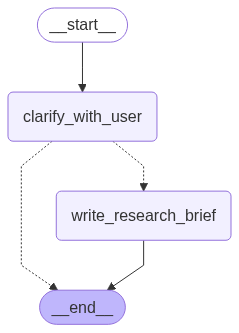

In [15]:
# Compile with in-memory checkpointer to test in notebook
from IPython.display import Image, display
from langgraph.checkpoint.memory import InMemorySaver
# from deep_research_from_scratch.research_agent_scope import deep_researcher_builder

checkpointer = InMemorySaver()
""" CHECKPOINTER
Suppose you have a multi-step agent:
The user asks for a research report.
The agent first clarifies with the user (asks questions).
Then it writes the report.

Now imagine the conversation is interrupted after step 2 (user closes the 
notebook, server restarts, etc.).
Without a checkpointer, you'd lose all progress and need to restart.
With a checkpointer, you can resume from where you left off. It will be in RAM.
"""
scope = deep_researcher_builder.compile(checkpointer=checkpointer)
display(Image(scope.get_graph(xray=True).draw_mermaid_png()))

In [16]:
from rich.console import Console
from rich.panel import Panel
from rich.text import Text
import json
console = Console()

def format_message_content(message):
    """Convert message content to displayable string"""
    parts = []
    tool_calls_processed = False
    
    # Handle main content
    if isinstance(message.content, str):
        parts.append(message.content)
    elif isinstance(message.content, list):
        # Handle complex content like tool calls (Anthropic format)
        for item in message.content:
            if item.get('type') == 'text':
                parts.append(item['text'])
            elif item.get('type') == 'tool_use':
                parts.append(f"\n🔧 Tool Call: {item['name']}")
                parts.append(f"   Args: {json.dumps(item['input'], indent=2)}")
                parts.append(f"   ID: {item.get('id', 'N/A')}")
                tool_calls_processed = True
    else:
        parts.append(str(message.content))
    
    # Handle tool calls attached to the message (OpenAI format) - only if not already processed
    if not tool_calls_processed and hasattr(message, 'tool_calls') and message.tool_calls:
        for tool_call in message.tool_calls:
            parts.append(f"\n🔧 Tool Call: {tool_call['name']}")
            parts.append(f"   Args: {json.dumps(tool_call['args'], indent=2)}")
            parts.append(f"   ID: {tool_call['id']}")
    
    return "\n".join(parts)

def format_messages(messages):
    """Format and display a list of messages with Rich formatting"""
    for m in messages:
        msg_type = m.__class__.__name__.replace('Message', '')
        content = format_message_content(m)

        if msg_type == 'Human':
            console.print(Panel(content, title="🧑 Human", border_style="blue"))
        elif msg_type == 'Ai':
            console.print(Panel(content, title="🤖 Assistant", border_style="green"))
        elif msg_type == 'Tool':
            console.print(Panel(content, title="🔧 Tool Output", border_style="yellow"))
        else:
            console.print(Panel(content, title=f"📝 {msg_type}", border_style="white"))
# Run the workflow

# Run the workflow
# from utils import format_messages
from langchain_core.messages import HumanMessage

thread = {"configurable": {"thread_id": "1"}}
"""
Here, thread is just a configuration dictionary you're passing to invoke.
The "configurable" key is special in LangGraph: it lets you attach metadata 
(like thread_id) to the run.

Why thread_id?
When using a checkpointer (e.g., InMemorySaver, SqliteSaver), the system needs 
to know which conversation or workflow execution the state belongs to.
That's what thread_id is: a unique identifier for a conversation / run / session.

This way:
You can run multiple conversations in parallel without overwriting each other's 
state.
You can later resume exactly the right conversation from the checkpointer.
So the same checkpointer will hold multiple chats at once.
And we can resume them, see them as needed, by using the thread_id. 
"""
result = scope.invoke({"messages": [HumanMessage(content="I want to research the best coffee shops in")]}, config=thread)
format_messages(result['messages'])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ I want to research the best coffee shops in                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Could you please specify the location or city you are interested in for the best coffee shops?                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [ ]:
from rich.markdown import Markdown
Markdown(result["research_brief"])
# error as 'research_brief' is not in the result because the agent wants to
# clarify the user's intent before proceeding with research.

KeyError: 'research_brief'

In [18]:
result = scope.invoke({"messages": [HumanMessage(content="San Francisco")]}, config=thread)
format_messages(result['messages'])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ I want to research the best coffee shops in                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Could you please specify the location or city you are interested in for the best coffee shops?                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ San Francisco                                                                                                   │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ I have sufficient information to proceed with your request for researching the best coffee shops in San         │
│ Francisco. I will now begin the research process.                                                               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [19]:
from rich.markdown import Markdown
Markdown(result["research_brief"])

What are the top-rated coffee shops in San Francisco, considering factors such as coffee quality, ambiance,        
customer service, and unique offerings, while prioritizing reviews from reputable sources like Yelp, Google        
Reviews, and local food blogs?

### Evaluation (Is our system working as intended?)
* Only checking if everything is captured in research_brief
* Not checking if agents are asking clarifying questions (conversation contains 
the clarifications)
* The agent graph only needs to generate the research_brief which will be 
evaluated

In [20]:
from langchain_core.messages import AIMessage

conversation_1 = [
    HumanMessage(content="What's the best way to invest $50,000 for retirement?"),
    AIMessage(content="Could you please provide some additional information to tailor the investment advice for your $50,000 retirement goal? Specifically:\n Your current age or desired retirement age\n Your risk tolerance (low, medium, high)\n Any preferences for investment types (e.g., stocks, bonds, mutual funds, real estate)\n Whether you are investing through a tax-advantaged account (e.g., IRA, 401(k)) or a regular brokerage account\n This will help me provide more personalized and relevant suggestions."),
    HumanMessage(content="I'm 25 and I want to retire by 45. My risk tolerance is high right now but I think will decrease over time. I have heard that stocks and ETFs are a good choice, but I'm open to anything. And I already have a 401k, but this would just be through a regular brokerage account."),
]

conversation_2 = [
    HumanMessage(content="I am looking for an apartment in NYC, can you help me?"),
    AIMessage(content="Could you please specify your apartment preferences? For example:\n Desired neighborhoods or boroughs\n Number of bedrooms/bathrooms\n Budget range (monthly rent)\n Any amenities or must-have features\n Preferred move-in date\n This information will help me provide the most relevant apartment options in NYC."),
    HumanMessage(content="I'd prefer to live in Chelsea, Flatiron, or West Village. I'm looking for a 2 bed 2 bath, and I am looking for monthly rent below 7k. I'd like this to be a doorman building and have an in unit washer and dryer, but it's okay if there's no washer dryer. It's a plus if the building has a gym. And I'd like to move in in September 2025."),
]

In [21]:
criteria_1 = [
    "Current age is 25",
    "Desired retirement age is 45",
    "Current risk tolerance is high",
    "Interested in investing in stocks and ETFs",
    "Open to forms of investment beyond stocks and ETFs"
    "Investment account is a regular brokerage account",
]

criteria_2 = [
    "Looking for a 2 bed 2 bath apartment in Chelsea, Flatiron, or West Village",
    "Monthly rent below 7k",
    "Should be in a doorman building",
    "Ideally have an in unit washer and dryer but not strict",
    "Ideally have a gym but not strict",
    "Move in date is September 2025"
]

In [ ]:
import os
from langsmith import Client
"""
Create the dataset on langsmith and populate it with examples.
"""
# Initialize the LangSmith client
langsmith_client = Client(api_key=os.getenv("LANGSMITH_API_KEY"))

# Create the dataset
dataset_name = "deep_research_scoping"
if not langsmith_client.has_dataset(dataset_name=dataset_name):
    
    # Create the dataset
    dataset = langsmith_client.create_dataset(
        dataset_name=dataset_name,
        description="A dataset that measures the quality of research briefs generated from an input conversation",
    )

    # Add the examples to the dataset
    langsmith_client.create_examples(
        dataset_id=dataset.id,
        examples=[
            {
                "inputs": {"messages": conversation_1},
                "outputs": {"criteria": criteria_1},
            },
            {
                "inputs": {"messages": conversation_2},
                "outputs": {"criteria": criteria_2},
            },
        ],
    )

In [23]:
from prompts import BRIEF_CRITERIA_PROMPT
show_prompt(BRIEF_CRITERIA_PROMPT, "BRIEF_CRITERIA_PROMPT")

╭───────────────────────────────────────────── BRIEF_CRITERIA_PROMPT ─────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│  <role>                                                                                                         │
│  You are an expert research brief evaluator specializing in assessing whether generated research briefs         │
│  accurately capture user-specified criteria without loss of important details.                                  │
│  </role>                                                                                                        │
│                                                                                                                 │
│  <task>                                                                                                         │
│  Determine if the research brief adequately captures the specific success criterion provided. Return a binary   │
│  assessment with detailed reasoning.                                                                            │
│  </task>                                                                                                        │
│                                                                                                                 │
│  <evaluation_context>                                                                                           │
│  Research briefs are critical for guiding downstream research agents. Missing or inadequately captured          │
│  criteria can lead to incomplete research that fails to address user needs. Accurate evaluation ensures         │
│  research quality and user satisfaction.                                                                        │
│  </evaluation_context>                                                                                          │
│                                                                                                                 │
│  <criterion_to_evaluate>                                                                                        │
│  {criterion}                                                                                                    │
│  </criterion_to_evaluate>                                                                                       │
│                                                                                                                 │
│  <research_brief>                                                                                               │
│  {research_brief}                                                                                               │
│  </research_brief>                                                                                              │
│                                                                                                                 │
│  <evaluation_guidelines>                                                                                        │
│  CAPTURED (criterion is adequately represented) if:                                                             │
│  - The research brief explicitly mentions or directly addresses the criterion                                   │
│  - The brief contains equivalent language or concepts that clearly cover the criterion                          │
│  - The criterion's intent is preserved even if worded differently                                               │
│  - All key aspects of the criterion are represented in the brief                                                │
│                                                                                                                 │
│  NOT CAPTURED (criterion is missing or inadequately ad

In [ ]:
from typing_extensions import cast
from pydantic import BaseModel, Field
from langchain_openai import ChatOpenAI

class Criteria(BaseModel):
    """
    Individual success criteria evaluation result.
    
    This model represents a single evaluation criteria that should be present
    in the research brief, along with a detailed assessment of whether it was
    successfully captured and the reasoning behind that assessment.
    """
    criteria_text: str = Field(
        description="The specific success criteria being evaluated (e.g., 'Current age is 25', 'Monthly rent below 7k')"
    )
    reasoning: str = Field(
        description="Detailed explanation of why this criteria is or isn't captured in the research brief, including specific evidence from the brief"
    )
    is_captured: bool = Field(
        description="Whether this specific criteria is adequately captured in the research brief (True) or missing/inadequately addressed (False)"
    )

def evaluate_success_criteria(outputs: dict, reference_outputs: dict):
    """
    Evaluate whether the research brief captures all required success criteria.
    
    This function evaluates each criterion individually to provide focused assessment
    and detailed reasoning for each evaluation decision.
    
    Args:
        outputs: Dictionary containing the research brief to evaluate
        reference_outputs: Dictionary containing the list of success criteria
        # Langsmith wraps the outputs from the dataset into reference_outputs
        # to pass into the evaluator

    Returns:
        Dict with evaluation results including score (0.0 to 1.0)
    """
    research_brief = outputs["research_brief"]
    success_criteria = reference_outputs["criteria"]

    model = ChatOpenAI(model="gpt-4o-mini", temperature=0)
    
    structured_output_model = model.with_structured_output(Criteria)
    
    # Run evals
    responses = structured_output_model.batch([
    [
        HumanMessage(
            content=BRIEF_CRITERIA_PROMPT.format(
                research_brief=research_brief,
                criterion=criterion
            )
        )
    ] 
    for criterion in success_criteria])
    
    # Ensure the criteria_text field is populated correctly
    individual_evaluations = [
        Criteria(
            reasoning=response.reasoning,
            criteria_text=criterion,
            is_captured=response.is_captured
        )
        for criterion, response in zip(success_criteria, responses)
    ]
    
    # Calculate overall score as percentage of captured criteria
    captured_count = sum(1 for eval_result in individual_evaluations if eval_result.is_captured)
    total_count = len(individual_evaluations)
    
    return {
        "key": "success_criteria_score", 
        "score": captured_count / total_count if total_count > 0 else 0.0,
        "individual_evaluations": [
            {
                "criteria": eval_result.criteria_text,
                "captured": eval_result.is_captured,
                "reasoning": eval_result.reasoning
            }
            for eval_result in individual_evaluations
        ]
    }

In [35]:
from prompts import BRIEF_HALLUCINATION_PROMPT
show_prompt(BRIEF_HALLUCINATION_PROMPT, "BRIEF_HALLUCINATION_PROMPT")

╭────────────────────────────────────────── BRIEF_HALLUCINATION_PROMPT ───────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│  ## Brief Hallucination Evaluator                                                                               │
│                                                                                                                 │
│  <role>                                                                                                         │
│  You are a meticulous research brief auditor specializing in identifying unwarranted assumptions that could     │
│  mislead research efforts.                                                                                      │
│  </role>                                                                                                        │
│                                                                                                                 │
│  <task>                                                                                                         │
│  Determine if the research brief makes assumptions beyond what the user explicitly provided. Return a binary    │
│  pass/fail judgment.                                                                                            │
│  </task>                                                                                                        │
│                                                                                                                 │
│  <evaluation_context>                                                                                           │
│  Research briefs should only include requirements, preferences, and constraints that users explicitly stated    │
│  or clearly implied. Adding assumptions can lead to research that misses the user's actual needs.               │
│  </evaluation_context>                                                                                          │
│                                                                                                                 │
│  <research_brief>                                                                                               │
│  {research_brief}                                                                                               │
│  </research_brief>                                                                                              │
│                                                                                                                 │
│  <success_criteria>                                                                                             │
│  {success_criteria}                                                                                             │
│  </success_criteria>                                                                                            │
│                                                                                                                 │
│  <evaluation_guidelines>                                                                                        │
│  PASS (no unwarranted assumptions) if:                                                                          │
│  - Brief only includes explicitly stated user requirements                                                      │
│  - Any inferences are clearly marked as such or logically necessary                                             │
│  - Source suggestions are general recommendations, not specific assumptions                                     │
│  - Brief stays within the scope of what the user actually requested                                             │
│                                                       

In [ ]:
# Improved NoAssumptions class with reasoning field and enhanced descriptions
class NoAssumptions(BaseModel):
    """
    Evaluation model for checking if research brief makes unwarranted assumptions.
    
    This model evaluates whether the research brief contains any assumptions,
    inferences, or additions that were not explicitly stated by the user in their
    original conversation. It provides detailed reasoning for the evaluation decision.
    """
    no_assumptions: bool = Field(
        description="Whether the research brief avoids making unwarranted assumptions. True if the brief only includes information explicitly provided by the user, False if it makes assumptions beyond what was stated."
    )
    reasoning: str = Field(
        description="Detailed explanation of the evaluation decision, including specific examples of any assumptions found or confirmation that no assumptions were made beyond the user's explicit statements."
    )

def evaluate_no_assumptions(outputs: dict, reference_outputs: dict):
    """
    Evaluate whether the research brief avoids making unwarranted assumptions.
    
    This evaluator checks that the research brief only includes information
    and requirements that were explicitly provided by the user, without
    making assumptions about unstated preferences or requirements.
    
    Args:
        outputs: Dictionary containing the research brief to evaluate
        reference_outputs: Dictionary containing the success criteria for reference
        # Langsmith wraps the outputs from the dataset into reference_outputs
        # to pass into the evaluator
    Returns:
        Dict with evaluation results including boolean score and detailed reasoning
    """
    research_brief = outputs["research_brief"]
    success_criteria = reference_outputs["criteria"]
    
    model = ChatOpenAI(model="gpt-4o-mini", temperature=0)
    structured_output_model = model.with_structured_output(NoAssumptions)
    
    response = structured_output_model.invoke([
        HumanMessage(content=BRIEF_HALLUCINATION_PROMPT.format(
            research_brief=research_brief, 
            success_criteria=str(success_criteria)
        ))
    ])
    
    return {
        "key": "no_assumptions_score", 
        "score": response.no_assumptions,
        "reasoning": response.reasoning
    }

In [ ]:
import uuid
# uuid is Python’s built-in library for generating universally unique identifiers.
# This ensures each run/thread has a unique ID.

def target_func(inputs: dict):
    config = {"configurable": {"thread_id": uuid.uuid4()}}
    return scope.invoke(inputs, config=config)

langsmith_client.evaluate(
    target_func, # The function to evaluate (In this case, agent)
    data=dataset_name,
    evaluators=[evaluate_success_criteria, evaluate_no_assumptions],
    # Langsmith wraps the outputs from the dataset into reference_outputs
    # to pass into the evaluator. Outputs are returned from target_func.
    experiment_prefix="Deep Research Scoping",
)

View the evaluation results for experiment: 'Deep Research Scoping-89ee0aad' at:
https://smith.langchain.com/o/4f952033-f3f7-5284-88d5-e49a2cedb48a/datasets/4a001728-3c8a-42d1-901b-b0c0a513e34f/compare?selectedSessions=06c6c676-1792-444c-bf16-0bad2ec153d3




0it [00:00, ?it/s]

,inputs.messages,outputs.messages,outputs.research_brief,outputs.supervisor_messages,outputs.raw_notes,outputs.notes,error,reference.criteria,feedback.success_criteria_score,feedback.no_assumptions_score,execution_time,example_id,id
0,"[{'type': 'human', 'content': 'What's the best...","[content=""What's the best way to invest $50,00...",What are the most effective investment strateg...,[content='What are the most effective investme...,[],[],None,"[Current age is 25, Desired retirement age is ...",0.8,True,4.781954,7da9912f-dfdb-4ea7-b4de-84676e7a8bc1,206dfde2-ffb0-4253-a3b3-b5b87523ded2
1,"[{'type': 'human', 'content': 'I am looking fo...",[content='I am looking for an apartment in NYC...,"I am looking for a 2 bedroom, 2 bathroom apart...","[content=""I am looking for a 2 bedroom, 2 bath...",[],[],None,[Looking for a 2 bed 2 bath apartment in Chels...,1.0,True,5.168482,d00efaeb-1325-4adc-bcf2-34ecd461893a,3391d827-b046-4c7f-b0a9-6eb74d0b4b06
